# Feature Engineering

In this notebook, I aim to create features that I think will have some predictive power.

**Please Note: Restarting this notebook will cause errors in the code since all the data is not stored locally.**

## Contents
[Tendencies](#Tendencies)<br>
[Score Differential Segments](#Score-Differential-Segments)<br>
[Distance Segments](#Distance-Segments)<br>
[Field Segments](#Field-Segments)<br>
[Possession Team & Defensive Team](#Possession-Team-&-Defensive-Team)

In [1]:
import pandas as pd
import s3fs
import numpy as np

from plot_plays_over_time import line_plot

pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999999)

import warnings
warnings.filterwarnings("ignore")

In [2]:
fs = s3fs.S3FileSystem(anon=False,key='AWS KEY',secret='AWS SECRET KEY')

key = 'nfl_play_by_play_with_weather_post_eda.csv'
bucket = 'nfl-play-by-play-capstone'

df = pd.read_csv(fs.open('{}/{}'.format(bucket, key),
                         mode='rb')).drop(columns=['Unnamed: 0'])

### Tendencies

In this section, I will build a feature that calculates the rolling average play call for the past 5 plays. For example, if a team has called run on 2 of the last 5 plays, the run tendency will be 0.4. Hopefully this can capture how play calls might differ as a game progresses.

This code does work, but the loop takes about 20 minutes to run. I saved the calculations in my datasets folder, and I will merge it with my play-by-play data in the nex cell.

```python
new_df = pd.DataFrame(columns = ['effective_run','effective_pass','run_tendency','pass_tendency'])
for i in list(df['game_id'].unique()):
    team_one, team_two = list(df[df['game_id'] == i]['posteam'].unique())
    team_one_df = df[(df['game_id'] == i) & (df['posteam'] == team_one)][['effective_run','effective_pass']]
    team_one_df['run_tendency'] = team_one_df['effective_run'].shift(1).rolling(5,min_periods=1).mean().fillna(0)
    team_one_df['pass_tendency'] = team_one_df['effective_pass'].shift(1).rolling(5,min_periods=1).mean().fillna(0)
    team_two_df = df[(df['game_id'] == i) & (df['posteam'] == team_two)][['effective_run','effective_pass']]
    team_two_df['run_tendency'] = team_two_df['effective_run'].shift(1).rolling(5,min_periods=1).mean().fillna(0)
    team_two_df['pass_tendency'] = team_two_df['effective_pass'].shift(1).rolling(5,min_periods=1).mean().fillna(0)
    game_df = pd.concat([team_one_df,team_two_df])
    new_df = pd.concat([new_df,game_df])
    clear_output()
    print(new_df.shape)
    
new_df.to_csv('../datasets/tendencies.csv')
```

In [3]:
new_df = pd.read_csv('../datasets/tendencies.csv',index_col='Unnamed: 0')
df = df.join(new_df[['run_tendency','pass_tendency']])

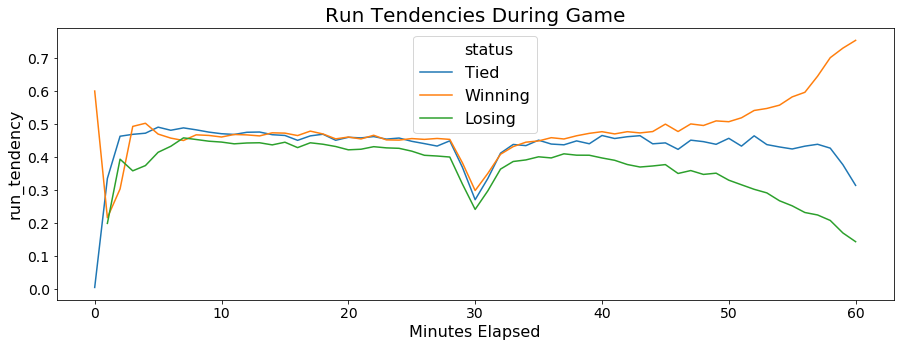

In [4]:
line_plot(df,play='run_tendency',title='Run Tendencies During Game')

As you can see, the relationship still holds: Winning teams are more likely to run for the last 5 plays in the last 10 minutes.

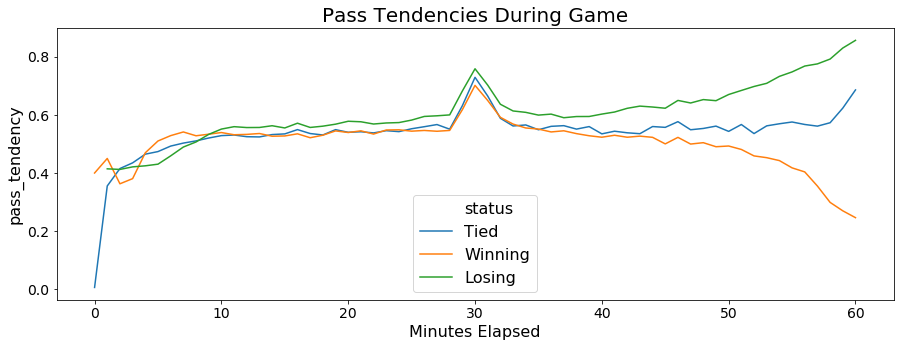

In [5]:
line_plot(df,play='pass_tendency',title='Pass Tendencies During Game')

Similarly, losing teams are more likely to pass for the last 5 plays in the last 10 minutes.

### Score Differential Segments

In this section, I wanted to segment the score differential based on how much a team was up/down by.

In [6]:
mask = [df['score_differential'].between(-8,-4), df['score_differential'].between(-3,-1), 
            df['score_differential'].between(4, 8), df['score_differential'].between(1,3),
            df['score_differential'].between(-100,-9), df['score_differential'].between(9,100),
            df['score_differential'].between(0,0)]
        
values = ['Down by 1 TD', 'Down by 1 FG', 'Up by 1 TD','Up by 1 FG', 'Down by more than 1 TD',
          'Up by more than 1 TD','Tied']
df['score_differential_segments'] = np.select(mask, values, 0)

In [7]:
df.groupby(['score_differential_segments'])[['effective_run','effective_pass']].mean()

,effective_run,effective_pass
score_differential_segments,,
Down by 1 FG,0.391787,0.608213
Down by 1 TD,0.378525,0.621475
Down by more than 1 TD,0.293199,0.706801
Tied,0.449996,0.550004
Up by 1 FG,0.464866,0.535134
Up by 1 TD,0.482594,0.517406
Up by more than 1 TD,0.560631,0.439369


Teams that are down by more than 1 TD pass the most while teams that are up by more than 1 TD run the most. The next step would be to dummy these columns. However, these dummies did not prove to make the model better, so I did not include these features in the end.

`df = df.join(pd.get_dummies(df['score_differential_segments'],drop_first=True))`

In [8]:
df = df.drop(columns=['score_differential_segments'])

### Distance Segments

In this section, I aim to differentiate between short, medium, and long yardage.

In [9]:
mask = [df['ydstogo'].between(0,3), df['ydstogo'].between(4,7), df['ydstogo'].between(8,100)]
values = ['Short','Medium','Long']
df['distance'] = np.select(mask, values, 0)
df.groupby(['down','distance'])[['effective_run','effective_pass']].mean()

effective_run  effective_pass
down distance                               
1.0  Long           0.510238        0.489762
     Medium         0.588264        0.411736
     Short          0.695621        0.304379
2.0  Long           0.351136        0.648864
     Medium         0.462019        0.537981
     Short          0.630200        0.369800
3.0  Long           0.136081        0.863919
     Medium         0.121155        0.878845
     Short          0.448076        0.551924
4.0  Long           0.113614        0.886386
     Medium         0.137550        0.862450
     Short          0.548088        0.451912

4th & Long and 3rd & Long were passes more than 86% of the time. Short plays typically resulted in runs. Now I am going to make some interaction terms to capture these scenarios.

In [10]:
copy_df = df[['down','distance']]
copy_df = copy_df.join(pd.get_dummies(copy_df['distance']))
copy_df = copy_df.join(pd.get_dummies(copy_df['down'].astype(str)))
copy_df['1_short'] = copy_df['1.0']*copy_df['Short']
copy_df['1_medium'] = copy_df['1.0']*copy_df['Medium']
copy_df['1_long'] = copy_df['1.0']*copy_df['Long']
copy_df['2_short'] = copy_df['2.0']*copy_df['Short']
copy_df['2_medium'] = copy_df['2.0']*copy_df['Medium']
copy_df['2_long'] = copy_df['2.0']*copy_df['Long']
copy_df['3_short'] = copy_df['3.0']*copy_df['Short']
copy_df['3_medium'] = copy_df['3.0']*copy_df['Medium']
copy_df['3_long'] = copy_df['3.0']*copy_df['Long']
copy_df['4_short'] = copy_df['4.0']*copy_df['Short']
copy_df['4_medium'] = copy_df['4.0']*copy_df['Medium']
copy_df['4_long'] = copy_df['4.0']*copy_df['Long']
df = df.join(copy_df.drop(columns=['down','distance']))
df = df.drop(columns=['distance'])

### Field Segments

In this section, I segmented the field into 5 areas: Goaline (inside opponents 10 yardline), Redzone (opponents 30-10 yardline), Middle of Field (between own 30 yardline and opponents 30 yardline), Own Redzone (between own 30 and 10 yardline), and Backed Up (inside own 10 yardline).

In [11]:
mask = [df['yardline_100'].between(0,10), df['yardline_100'].between(11,30), df['yardline_100'].between(31,70),
           df['yardline_100'].between(71,90), df['yardline_100'].between(91,100)]
values = ['Goal line','Redzone','Middle of Field','Own Redzone', 'Backed up']
df['yardline_zone'] = np.select(mask, values, 0)

In [12]:
df.groupby(['yardline_zone'])[['effective_run','effective_pass']].mean()

,effective_run,effective_pass
yardline_zone,,
Backed up,0.526656,0.473344
Goal line,0.502778,0.497222
Middle of Field,0.407338,0.592662
Own Redzone,0.412310,0.587690
Redzone,0.428862,0.571138


Teams seem to pass more as they progress down the field.

In [13]:
df = df.drop(columns=['yardline_zone'])

### Possession Team & Defensive Team

In this section, I am going to make dummies for which team is on offense and which team is on defense.

In [14]:
df = df.join(pd.get_dummies(df['posteam'], prefix='Poss',drop_first=True))
df = df.join(pd.get_dummies(df['defteam'], prefix='Def',drop_first=True))

Finally, I will eliminate any other features that I am not going to use in the model, and save the dataframe back to S3.

In [15]:
df = df.drop(columns=['game_id','game_date','year','desc','play_type','home_timeouts_remaining',
                      'away_timeouts_remaining','total_home_score','total_away_score','posteam_score',
                      'defteam_score','wind_speed','posteam_conference_division','posteam_status',
                      'Long','Medium','Short','1.0','2.0','3.0','4.0','own_side','second_half','posteam_winning',
                      'minutes_elapsed'])

In [16]:
fs = s3fs.S3FileSystem(anon=False,key='AWS KEY',secret='AWS SECRET KEY')

bucket = 'nfl-play-by-play-capstone'

with fs.open(f'{bucket}/nfl_play_by_play_with_weather_model.csv','w') as f:
    df.to_csv(f)